## 实验：Batch Normalization 算法

### 实验概要

Batch Normalization（批量标准化/归一化，简称 BN）是 2015 年提出的方法，近些年来成为深度学习优化中一个重要的手段。BN 本质也是一种解决深度神经网络随着网络深度加深，训练起来越困难，收敛越来越慢的一种技术。

#### BN 的思想

BN 的基本思想其实相当直观：因为深层神经网络在做非线性变换前的激活输入值（就是那个 $\sigma(Wx+b)$，$\sigma$ 是输入）随着网络深度加深或者在训练过程中，其分布逐渐发生偏移或者变动，**之所以训练收敛慢，一般是整体分布逐渐往非线性函数的取值区间的上下限两端靠近**（对于 Sigmoid 函数来说，意味着激活输入值 $\sigma(Wx+b)$ 是大的负值或正值），**所以这导致反向传播时低层神经网络的梯度消失**，这是训练深层神经网络收敛越来越慢的本质原因，而 BN 就是通过一定的规范化手段，把每层神经网络任意神经元这个输入值的分布强行拉回到均值为 0 方差为 1 的标准正态分布，**其实就是把越来越偏的分布强制拉回比较标准的分布，这样使得激活输入值落在非线性函数对输入比较敏感的区域，这样输入的小变化就会导致损失函数较大的变化，意思是这样让梯度变大，避免梯度消失问题产生，而且梯度变大意味着学习收敛速度快，能大大加快训练速度**。

简单来说：**对于每个隐层神经元，把逐渐向非线性函数映射后向取值区间极限饱和区靠拢的输入分布强制拉回到均值为 0 方差为 1 的比较标准的正态分布，使得非线性变换函数的输入值落入对输入比较敏感的区域，以此避免梯度消失问题**。因为梯度一直都能保持比较大的状态，所以很明显对神经网络的参数调整效率比较高，就是变动大，就是说向损失函数最优值迈动的步子大，也就是说收敛地快。

#### BN 的优点

- 加速训练过程；
- 可以使用较大的学习率；
- 允许在深层网络中使用 sigmoid 这种易导致梯度消失的激活函数；
- 具有轻微地正则化效果，以此可以降低 dropout 的使用。

#### BN 的算法流程

- **输入：** 获得 Mini Batch 上的 x 值，$\mathcal{B}=\left\{x_{1 \ldots m}\right\}$
- **输出：** $\left\{y_{i}=\operatorname{BN}_{\gamma, \beta}\left(x_{i}\right)\right\}$

运算流程如下 ——

1. Mini Batch 取均值：

$$\mu_{\mathcal{B}} \leftarrow \frac{1}{m} \sum_{i=1}^{m} x_{i}$$

2. Mini Batch 方差：

$$\sigma_{\mathcal{B}}^{2} \leftarrow \frac{1}{m} \sum_{i=1}^{m}\left(x_{i}-\mu_{\mathcal{B}}\right)^{2}$$

3. Mini Batch 标准化：

$$\widehat{x}_{i} \leftarrow \frac{x_{i}-\mu_{\mathcal{B}}}{\sqrt{\sigma_{\mathcal{B}}^{2}+\epsilon}}$$

4. 平移和缩放：

$$y_{i} \leftarrow \gamma \widehat{x}_{i}+\beta \equiv \mathrm{BN}_{\gamma, \beta}\left(x_{i}\right)$$

简单地说，通过计算均值和方差后，mini-batch 的数据进行标准化，再加上 $\beta$ 和 $\gamma$ 可以使变量进行平移和缩放。加入缩放平移变量的原因是：保证每一次数据经过归一化后还保留原有学习来的特征，同时又能完成归一化操作，加速训练。这两个参数是用来学习的参数。通过 Python 实现 BN 代码如下：

In [1]:
import numpy as np

def Batchnorm(x, gamma, beta, bn_param):

    # x_shape:[B, C, H, W]
    running_mean = bn_param['running_mean']
    running_var = bn_param['running_var']
    results = 0.
    eps = 1e-5
    
    # 沿着通道计算每个batch的均值u
    x_mean = np.mean(x, axis=(0, 2, 3), keepdims=True)  
    # 沿着通道计算每个batch的方差σ^2
    x_var = np.var(x, axis=(0, 2, 3), keepdims=True)    
    # 对x做归一化，x’=(x-u)/开根号(σ^2+ε)
    x_normalized = (x - x_mean) / np.sqrt(x_var + eps)  
    # 加入缩放和平移变量γ和β ,归一化后的值，y=γx’+β
    results = gamma * x_normalized + beta               

    # 因为在测试时是单个图片测试，这里保留训练时的均值和方差，用在后面测试时用
    running_mean = momentum * running_mean + (1 - momentum) * x_mean
    running_var = momentum * running_var + (1 - momentum) * x_var

    bn_param['running_mean'] = running_mean
    bn_param['running_var'] = running_var

    return results, bn_param

### 实验目标

在本实验中，我们以 CIFAR-10 数据集为例，通过 BN 转换，来查看模型训练结果的前后变化。

CIFAR-10 数据集由 10 类 32x32 的彩色图片组成，一共包含 60,000 张图片，每一类包含 6,000 图片。其中 50,000 张图片作为训练集，10,000 张图片作为测试集。CIFAR-10 数据集被划分成了 5 个训练的批次和 1 个测试的批次，每个批次均包含 10,000 张图片。测试集批次的图片是从每个类别中随机挑选的 1,000 张图片组成的,训练集批次以随机的顺序包含剩下的 50,000 张图片。不过一些训练集批次可能出现包含某一类图片比其他类的图片数量多的情况。训练集批次包含来自每一类的 5,000 张图片，一共 50,000 张训练图片。

<img src="./img/cifar10_18.png">

### 1. 导入库

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow import keras
import os
from tensorflow.python.keras.datasets.cifar import load_batch

### 2. 加载数据及平滑化

可以使用 Keras 内置函数 `keras.datasets.cifar10.load_data()` 从网上自动下载 cifar10 数据集。

**首次下载需要较长时间，请耐心等待。**

在此我们已经下载好数据集了。

In [3]:
base_path = os.environ.get("BATH_PATH",'./data/')
data_path = os.path.join(base_path + "lab18/")
result_path = "result/"
os.makedirs(result_path, exist_ok=True)

def load_data():
    """Loads CIFAR10 dataset.
    Returns:
      Tuple of Numpy arrays: `(x_train, y_train), (x_test, y_test)`.
    """
    path = data_path + 'cifar-10-batches-py'

    num_train_samples = 50000

    x_train = np.empty((num_train_samples, 3, 32, 32), dtype='uint8')
    y_train = np.empty((num_train_samples,), dtype='uint8')

    for i in range(1, 6):
        fpath = os.path.join(path, 'data_batch_' + str(i))
        (x_train[(i - 1) * 10000:i * 10000, :, :, :],
         y_train[(i - 1) * 10000:i * 10000]) = load_batch(fpath)

    fpath = os.path.join(path, 'test_batch')
    x_test, y_test = load_batch(fpath)

    y_train = np.reshape(y_train, (len(y_train), 1))
    y_test = np.reshape(y_test, (len(y_test), 1))

    if K.image_data_format() == 'channels_last':
        x_train = x_train.transpose(0, 2, 3, 1)
        x_test = x_test.transpose(0, 2, 3, 1)

    x_test = x_test.astype(x_train.dtype)
    y_test = y_test.astype(y_train.dtype)

    return (x_train, y_train), (x_test, y_test)

(x_train, y_train), (x_test, y_test) = load_data()

可视化数据集中的图片，下面的代码展示了每个类型的训练图像的一些样本：

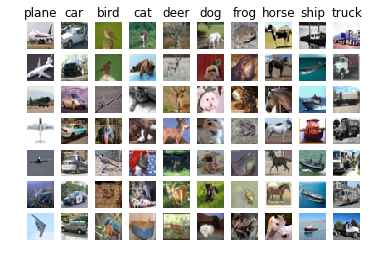

In [4]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(x_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

将图片平滑化，便于后续计算：

In [5]:
x = x_train[0].reshape(-1) / 255
print("x:", x.shape)

x: (3072,)


### 3. 模拟运算

#### 3.1 权重初始化

设：隐含层有 `1024` 个神经元，则权重为（1024，3072）

In [6]:
w = K.eval(K.random_normal_variable(shape=(1024, 3072), mean=0, scale=1))
print("w:", w.shape)

w: (1024, 3072)


#### 3.2 计算隐含层的输入

设：B 为隐含层的 Mini Batch 输入值，即：$\mathcal{B}=\left\{x_{1 \ldots m}\right\}$。代码为：

In [7]:
B = np.dot(w, x)
print("B:", B.shape)

B: (1024,)


#### 3.3 计算 z 的均值和方差

- 根据公式 $\mu_{\mathcal{B}} \leftarrow \frac{1}{m} \sum_{i=1}^{m} x_{i}$ 取 Mini Batch 均值
- 根据公式 $\sigma_{\mathcal{B}}^{2} \leftarrow \frac{1}{m} \sum_{i=1}^{m}\left(x_{i}-\mu_{\mathcal{B}}\right)^{2}$ 取 Mini Batch 方差

In [8]:
a = K.constant(B)

# 运算均值
mean = K.mean(a)
print("mean:", K.eval(mean))

# 计算方差
var = K.var(a)
print("var:", K.eval(var))

mean: -0.91418356
var: 650.75696


#### 3.4 对 B 进行 BN 转换

使用 Keras 的 BatchNormalization 类，可以一次性执行标准化、平移和缩放操作，其中：

- **`gamma`** 为 0，表示不进行移动
- **`beta`** 为 0.25，表示将标准化后的值压缩至 1/4 大小：

In [9]:
a = K.eval(K.batch_normalization(a, mean, var, 0, 0.25))
a = a.reshape(-1)
print("batch_normal_a:", a.shape)

batch_normal_a: (1024,)


#### 3.5 BN 转换效果可视化对比

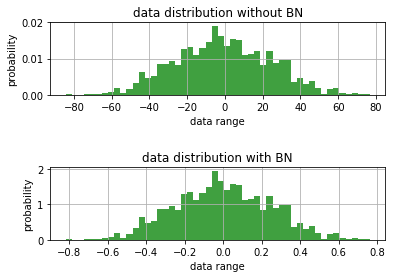

In [10]:
p1 = plt.subplot(211)
p1.hist(B, 50, density=1, facecolor='g', alpha=0.75)
p1.set_title("data distribution without BN")
p1.set_xlabel('data range')
p1.set_ylabel('probability')
p1.grid(True)

p2 = plt.subplot(212)
p2.hist(a, 50, density=1, facecolor='g', alpha=0.75)
p2.set_title("data distribution with BN")
p2.set_xlabel('data range')
p2.set_ylabel('probability')
p2.grid(True)

plt.subplots_adjust(hspace=1)
plt.show()

- 从图像分析可知，数据经过标准化后，其形状保持大致不变，但尺寸被我们压缩至（-1, 1）之间，而原尺寸在(-80，80)之间。
- 通过平移和缩放，BN 可以使数据被限定在我们想要的范围内，所以每层的输出数据都进行 BN 的话，可以使后层网络面对稳定的输入值，降低梯度发散的可能，从而加快训练速度；同时也意味着允许使用大点的学习率，加快收敛过程。

### 4. 神经网络 BN 应用

以上为通过数学运算，模拟 BN 转换的操作过程与实现效果。下面，我们将 BN 放置在实际的神经网络中应用，观察 BN 是否对我们的模型产生了影响。

#### 4.1 导入库

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D

#### 4.2 参数设置

由于训练时间很长，这里将 epochs 的值设置为 10，如果想有更明显的结果，可以增大 epochs 的值，譬如增加到 100 次。

In [12]:
np.random.seed(7)
batch_size = 32
num_classes = 10

# 调整 Epochs 次数
epochs = 10 

data_augmentation = True

#### 4.3 将整型类别转换为 one-hot 编码

In [13]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

### 5. 不使用 BN 搭建模型

In [14]:
model_without_bn = Sequential()
model_without_bn.add(Conv2D(32, (3, 3), padding='same',
                            input_shape=x_train.shape[1:]))
model_without_bn.add(Activation('relu'))
model_without_bn.add(Conv2D(32, (3, 3)))
model_without_bn.add(Activation('relu'))
model_without_bn.add(MaxPooling2D(pool_size=(2, 2)))
model_without_bn.add(Dropout(0.25))

model_without_bn.add(Conv2D(64, (3, 3), padding='same'))
model_without_bn.add(Activation('relu'))
model_without_bn.add(Conv2D(64, (3, 3)))
model_without_bn.add(Activation('relu'))
model_without_bn.add(MaxPooling2D(pool_size=(2, 2)))
model_without_bn.add(Dropout(0.25))

model_without_bn.add(Flatten())
model_without_bn.add(Dense(512))
model_without_bn.add(Activation('relu'))
model_without_bn.add(Dropout(0.5))
model_without_bn.add(Dense(num_classes))
model_without_bn.add(Activation('softmax'))

#### 5.1 模型编译

In [15]:
opt = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)

model_without_bn.compile(loss='categorical_crossentropy',
                         optimizer=opt,
                         metrics=['accuracy'])

#### 5.2 模型训练

> **训练时间预计 30 分钟，请耐心等待**

In [16]:
history_without_bn = model_without_bn.fit(x_train, y_train,
                                          batch_size=batch_size,
                                          epochs=epochs,
                                          validation_data=(x_test, y_test),
                                          shuffle=True)

Epoch 1/10
1563/1563 [==============================] - 243s 148ms/step - loss: 1.7858 - accuracy: 0.3444 - val_loss: 1.5224 - val_accuracy: 0.4417
Epoch 2/10
1563/1563 [==============================] - 216s 138ms/step - loss: 1.4880 - accuracy: 0.4615 - val_loss: 1.3965 - val_accuracy: 0.4962
Epoch 3/10
1563/1563 [==============================] - 188s 120ms/step - loss: 1.3388 - accuracy: 0.5241 - val_loss: 1.2574 - val_accuracy: 0.5547
Epoch 4/10
1563/1563 [==============================] - 128s 82ms/step - loss: 1.2325 - accuracy: 0.5642 - val_loss: 1.2404 - val_accuracy: 0.5606
Epoch 5/10
1563/1563 [==============================] - 102s 65ms/step - loss: 1.1534 - accuracy: 0.5924 - val_loss: 1.1098 - val_accuracy: 0.6140
Epoch 6/10
1563/1563 [==============================] - 96s 62ms/step - loss: 1.0883 - accuracy: 0.6179 - val_loss: 1.0432 - val_accuracy: 0.6352
Epoch 7/10
1563/1563 [==============================] - 96s 62ms/step - loss: 1.0320 - accuracy: 0.6384 - val_loss: 

### 6. 使用 BN 搭建模型

如前所述， BN 的思路是调整各层的激活值分布使其拥有适当的广度。为此，要向神经网络中插入对数据分布进行正规化的层，即 `Batch Normalization 层`：

<img src="./img/1_18.png" width="60%">

In [17]:
model_with_bn = Sequential()
model_with_bn.add(Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:]))
# 增加BN层
model_with_bn.add(BatchNormalization()) 
model_with_bn.add(Activation('relu'))
model_with_bn.add(Conv2D(32, (3, 3)))
# 增加BN层
model_with_bn.add(BatchNormalization()) 
model_with_bn.add(Activation('relu'))
model_with_bn.add(MaxPooling2D(pool_size=(2, 2)))

model_with_bn.add(Conv2D(64, (3, 3), padding='same'))
# 增加BN层
model_with_bn.add(BatchNormalization()) 
model_with_bn.add(Activation('relu'))
model_with_bn.add(Conv2D(64, (3, 3)))
# 增加BN层
model_with_bn.add(BatchNormalization()) 
model_with_bn.add(Activation('relu'))
model_with_bn.add(MaxPooling2D(pool_size=(2, 2)))

model_with_bn.add(Flatten())
model_with_bn.add(Dense(512))
# 增加BN层
model_with_bn.add(BatchNormalization()) 
model_with_bn.add(Activation('relu'))
model_with_bn.add(Dense(num_classes))
# 增加BN层
model_with_bn.add(BatchNormalization()) 
model_with_bn.add(Activation('softmax'))

进一步了解 BN 层的详细设置，可以 [参考官方文档](https://keras.io/api/layers/normalization_layers/batch_normalization/)。

#### 6.1 模型编译

In [18]:
opt = keras.optimizers.RMSprop(learning_rate=0.001, decay=1e-6)

model_with_bn.compile(loss='categorical_crossentropy',
                         optimizer=opt,
                         metrics=['accuracy'])

#### 6.2 模型训练

> **训练时间预计 30 分钟，请耐心等待**

In [19]:
history_with_bn = model_with_bn.fit(x_train, y_train,
                                              batch_size=batch_size,
                                              epochs=epochs,
                                              validation_data=(x_test, y_test),
                                              shuffle=True)

Epoch 1/10
1563/1563 [==============================] - 133s 83ms/step - loss: 1.1901 - accuracy: 0.6011 - val_loss: 1.1094 - val_accuracy: 0.6101
Epoch 2/10
1563/1563 [==============================] - 134s 86ms/step - loss: 0.8214 - accuracy: 0.7292 - val_loss: 1.0554 - val_accuracy: 0.6331
Epoch 3/10
1563/1563 [==============================] - 124s 79ms/step - loss: 0.6632 - accuracy: 0.7802 - val_loss: 0.7075 - val_accuracy: 0.7649
Epoch 4/10
1563/1563 [==============================] - 124s 79ms/step - loss: 0.5483 - accuracy: 0.8194 - val_loss: 0.7787 - val_accuracy: 0.7381
Epoch 5/10
1563/1563 [==============================] - 124s 79ms/step - loss: 0.4527 - accuracy: 0.8519 - val_loss: 0.6451 - val_accuracy: 0.7872
Epoch 6/10
1563/1563 [==============================] - 123s 78ms/step - loss: 0.3689 - accuracy: 0.8806 - val_loss: 0.7090 - val_accuracy: 0.7744
Epoch 7/10
1563/1563 [==============================] - 123s 79ms/step - loss: 0.3014 - accuracy: 0.9049 - val_loss: 0

### 7. 比较两种模型的精确度

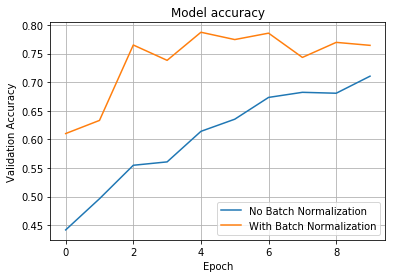

In [20]:
plt.plot(history_without_bn.history['val_accuracy'])
plt.plot(history_with_bn.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Validation Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Batch Normalization', 'With Batch Normalization'], loc='lower right')
plt.grid(True)
plt.show()

### 8. 比较两种模型的损失率

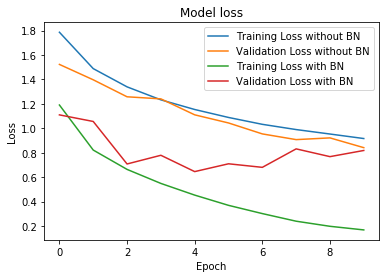

In [21]:
plt.plot(history_without_bn.history['loss'])
plt.plot(history_without_bn.history['val_loss'])
plt.plot(history_with_bn.history['loss'])
plt.plot(history_with_bn.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss without BN', 'Validation Loss without BN', 
            'Training Loss with BN', 'Validation Loss with BN'], 
           loc='upper right')
plt.show()

### 实验小结

在本实验中，你分别通过数学模拟运算与将 BN 层部署到真实的神经网络，实现 BN 转换的对比。从上面的实验结果中可以看出，BN 转换确实能有效提升神经网络的准确率并降低损失率，提升深度学习神经网络模型的健壮性与性能。